# Do Left-handed people really die young
# Lahah Ismail

## Contexte

Dans ce projet on va explorer une étude qui dise que les gauchers 
meurent en moyenne neuf ans plus tôt que les droitiers.

![img](datasets/Obama_signs_health_care-20100323.jpg)

On va importer les bibliothèques nécessaire pour éffectuer ce travail


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

 Ensuite, nous créons un nouveau DataFrame en important le fichier CSV

In [3]:
lefthanded_data = pd.read_csv("datasets/lh_data.csv")

On va voir les données dans les 5 permiers lignes

In [4]:
lefthanded_data.head()

,Age,Male,Female
0,10,12.717558,12.198041
1,11,15.318830,11.144804
2,12,14.808281,11.549240
3,13,13.793744,11.276442
4,14,15.156304,11.572906


Utilisons la méthode .plot()  pour créer un graphique des colonnes "Male" et "Female" par rapport à "Age".

Text(0, 0.5, 'Percentage of prople who are left-handed')

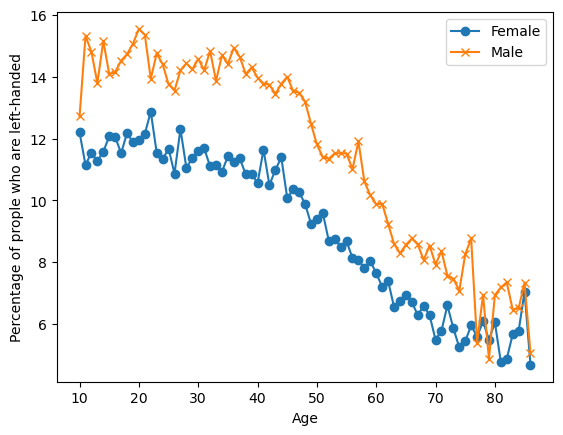

In [5]:
# plot male and female left-handedness rates vs. age
%matplotlib inline
fig, ax = plt.subplots() # create figure and axis objects
ax.plot('Age', 'Female', data = lefthanded_data, marker = 'o') # plot "Female" vs. "Age"
ax.plot('Age', 'Male', data = lefthanded_data, marker = 'x') # plot "Male" vs. "Age"
ax.legend() # add a legend
ax.set_xlabel("Age")
ax.set_ylabel("Percentage of prople who are left-handed")

Convertissons ces données en un graphique des taux de gaucher en fonction de l'année de naissance, et en moyenne sur les hommes et les femmes pour obtenir un taux unique pour les deux sexes.

Puisque l'étude a été réalisée en 1986, les données après cette conversion seront le pourcentage de personnes vivantes en 1986 qui sont gauchers en fonction de l'année de leur naissance.

Text(0, 0.5, 'Percentage left-handed')

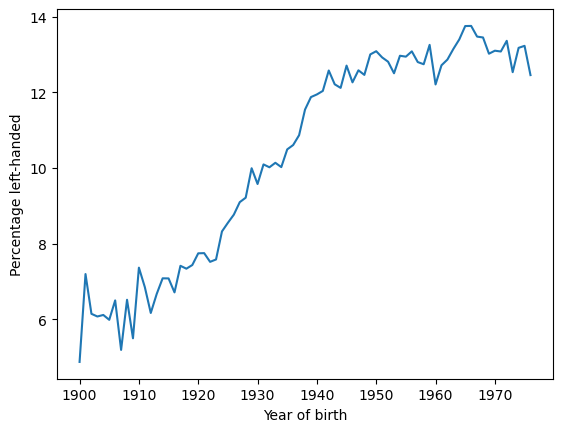

In [13]:
# create a new column for birth year of each age
lefthanded_data['Birth_year'] = 1986 - lefthanded_data['Age'] # the study was done in 1986

# create a new column for the average of male and female
lefthanded_data['Mean_lh'] = lefthanded_data[['Female', 'Male']].mean(axis = 1)

# create a plot of 'Mean_lh' vs. 'Birth_year'
fig, ax = plt.subplots()
ax.plot('Birth_year', 'Mean_lh', data = lefthanded_data)
ax.set_xlabel("Year of birth")
ax.set_ylabel("Percentage left-handed")

La probabilité de mourir à un certain âge sachant qu'on est gaucher n'est pas égale à la probabilité d'être 
droitier, donc :
   * On va  calculer la probabilité de mourir à l'âge A sachant que l'on est gaucher.
   * On veut aussi la même quantité pour les droitiers

In [21]:

# create a function for P(LH | A)
def P_lh_given_A(ages_of_death, study_year = 1990):
    """ P(Left-handed | age of death), calculated based on the reported rates of left-handedness.
    Inputs: age of death, study_year
    Returns: probability of left-handedness given that a subject died in `study_year` at age `age_of_death` """
    
    # Use the mean of the 10 neighbouring points for rates before and after the start 
    early_1900s_rate = lefthanded_data['Mean_lh'][-10:].mean()
    late_1900s_rate = lefthanded_data['Mean_lh'][:10].mean()
    middle_rates = lefthanded_data.loc[lefthanded_data['Birth_year'].isin(study_year - ages_of_death)]['Mean_lh']
    
    youngest_age = study_year - 1986 + 10 # the youngest age in the NatGeo dataset is 10
    oldest_age = study_year - 1986 + 86 # the oldest age in the NatGeo dataset is 86
    
    P_return = np.zeros(ages_of_death.shape)  # create an empty array to store the results
    # extract rate of left-handedness for people of age age_of_death
    P_return[ages_of_death > oldest_age] = early_1900s_rate / 100
    P_return[ages_of_death < youngest_age] = late_1900s_rate / 100
    P_return[np.logical_and((ages_of_death <= oldest_age), (ages_of_death >= youngest_age))] = middle_rates / 100
 
    return P_return

* Dans ce bloc, nous allons charger les données de distribution des décès et les tracer. La première colonne est l'âge, et les autres colonnes sont le nombre de personnes décédées à cet âge 
* Les données que nous utiliserons pour cela proviennent de l'ensemble des États-Unis pour l'année 1999 - le plus proche que j'ai pu trouver pour la période qui nous intéresse.

Text(0, 0.5, 'Number of people who died')

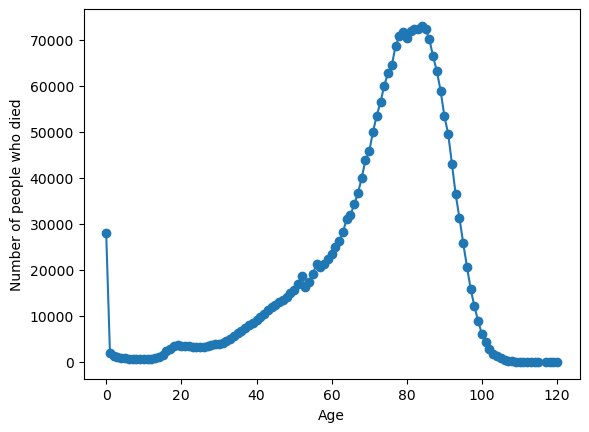

In [23]:
# Death distribution data for the United States in 1999
data_url_2 = "https://gist.githubusercontent.com/mbonsma/2f4076aab6820ca1807f4e29f75f18ec/raw/62f3ec07514c7e31f5979beeca86f19991540796/cdc_vs00199_table310.tsv"

# load death distribution data
death_distribution_data = pd.read_csv(data_url_2, sep = '\t', skiprows=[1])

# drop NaN values from the `Both Sexes` column
death_distribution_data = death_distribution_data.dropna(subset = ["Both Sexes"]) # drop NaN from'Both Sexes' column

# plot number of people who died as a function of age
fig, ax = plt.subplots()
ax.plot('Age', 'Both Sexes', data = death_distribution_data, marker='o')
ax.set_xlabel("Age")
ax.set_ylabel("Number of people who died")

Dans le bloc de code précédent, nous avons chargé des données pour nous donner P(A), et maintenant nous avons besoin de P(LH). P(LH) est la probabilité qu'une personne décédée au cours de notre année d'étude particulière soit gauchère

In [24]:
def P_lh(death_distribution_data, study_year = 1990): # sum over P_lh for each age group
    """ Overall probability of being left-handed if you died in the study year
    P_lh = P(LH | Age of death) P(Age of death) + P(LH | not A) P(not A) = sum over ages 
    Input: dataframe of death distribution data
    Output: P(LH), a single floating point number """
    p_list = death_distribution_data['Both Sexes']*P_lh_given_A(death_distribution_data['Age'], study_year)
    p = np.sum(p_list)
    return p/np.sum(death_distribution_data['Both Sexes']) # normalize to total number of people in distribution

print(P_lh(death_distribution_data))

0.07766387615350638


Nous avons maintenant les moyens de calculer les trois quantités dont nous avons besoin : P(A), P(LH) et P(LH | A). Nous pouvons combiner les trois en utilisant la règle de Bayes pour obtenir P(A | LH)

In [25]:
def P_A_given_lh(ages_of_death, death_distribution_data, study_year = 1990):
    """ The overall probability of being a particular `age_of_death` given that you're left-handed """
    P_A = death_distribution_data['Both Sexes'][ages_of_death] / np.sum(death_distribution_data['Both Sexes'])
    P_left = P_lh(death_distribution_data, study_year) # use P_lh function to get probability of left-handedness overall
    P_lh_A = P_lh_given_A(ages_of_death, study_year) # use P_lh_given_A to get probability of left-handedness for a certain age
    return P_lh_A*P_A/P_left

Maintenant pour les droitiers

In [26]:
def P_A_given_rh(ages_of_death, death_distribution_data, study_year = 1990):
    """ The overall probability of being a particular `age_of_death` given that you're right-handed """
    P_A = death_distribution_data['Both Sexes'][ages_of_death] / np.sum(death_distribution_data['Both Sexes'])
    P_right = 1- P_lh(death_distribution_data, study_year) # either you're left-handed or right-handed, so these sum to 1
    P_rh_A = 1-P_lh_given_A(ages_of_death, study_year) # these also sum to 1 
    return P_rh_A*P_A/P_right

On va Tracer la probabilité d'avoir un certain âge au moment du décès étant donné que vous êtes gaucher ou droitier pour une tranche d'âge.

Text(0, 0.5, 'Probability of being age A at death')

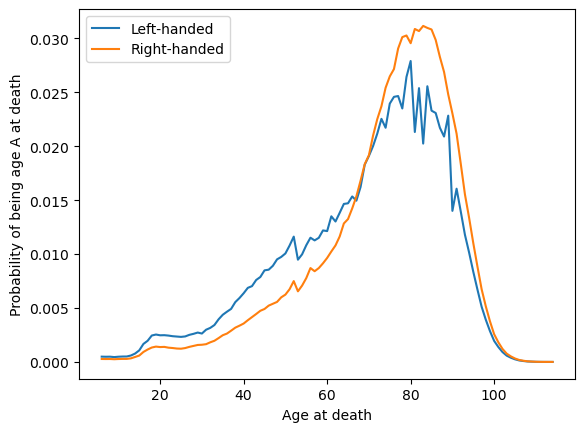

In [28]:
ages = np.arange(6,115,1) # make a list of ages of death to plot

# for each age, calculate the probability of being left- or right-handed
left_handed_probability = P_A_given_lh(ages, death_distribution_data)
right_handed_probability = P_A_given_rh(ages, death_distribution_data)

fig, ax = plt.subplots() # create figure and axis objects
ax.plot(ages, left_handed_probability, label = "Left-handed")
ax.plot(ages, right_handed_probability, label = "Right-handed")
ax.legend()
ax.set_xlabel("Age at death")
ax.set_ylabel(r"Probability of being age A at death")

Maintenant, on va Trouver l'âge moyen au décès des gauchers et des droitiers.

In [29]:
# calculate average ages for left-handed and right-handed groups
# use np.array so that two arrays can be multiplied
average_lh_age =  np.nansum(ages*np.array(left_handed_probability))
average_rh_age =  np.nansum(ages*np.array(right_handed_probability))

# print the average ages for each group
print(round(average_lh_age,1))
print(round(average_rh_age,1))

# print the difference between the average ages
print("The difference in average ages is " + str(round(average_rh_age - average_lh_age, 1)) + " years.")

67.2
72.8
The difference in average ages is 5.5 years.


# Derniers commentaires
Nous avons un assez grand écart d'âge entre les gauchers et les droitiers uniquement en raison de l'évolution des taux de gaucher dans la population, ce qui est une bonne nouvelle pour les gauchers : vous ne mourrez probablement pas jeune à cause de votre sinistre. Les taux signalés de gaucher sont passés de seulement 3% au début des années 1900 à environ 11% aujourd'hui, ce qui signifie que les personnes âgées sont beaucoup plus susceptibles d'être signalées comme droitières que gauchers, et donc en regardant un échantillon des personnes récemment décédées auront plus de droitiers âgés.

On va refaire le calcul de la tâche 8, en définissant le study_yearparamètre sur 2018.

In [31]:
# loop through ages, calculating the probability of being left- or right-handed
left_handed_probability_2018 = P_A_given_lh(ages, death_distribution_data, study_year = 2018)
right_handed_probability_2018 = P_A_given_rh(ages, death_distribution_data, study_year = 2018)
    
# calculate average ages for left-handed and right-handed groups
average_lh_age_2018 =  np.nansum(ages*np.array(left_handed_probability_2018))
average_rh_age_2018 =  np.nansum(ages*np.array(right_handed_probability_2018))

print("The difference in average ages is " + 
      str(round(average_rh_age_2018 - average_lh_age_2018, 1)) + " years.")

The difference in average ages is 2.3 years.
